In [62]:
!pip install -q feature_engine

In [63]:
#Import libraries
import numpy as np #linear algebra
import pandas as pd #data preprocessing CSV file I/O (eg pd.read_csv)

import warnings
warnings.filterwarnings('ignore')

import shap #SHAP(SHapley Additive exPlanation) aa game theoritic approach to explain the output of any machine learning model
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostClassifier
from feature_engine.encoding import RareLabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score# Receiver Operating characteristics 
from sklearn.model_selection import train_test_split
import seaborn as sns
import itertools

pd.set_option('display.max_rows', 1000)

In [64]:
df=pd.read_csv('road-casualty-statistics-22.csv').drop_duplicates()
print(df.shape)
df.sample(5).T

(61352, 20)


,27933,15969,29181,26507,47440
status,Unvalidated,Unvalidated,Unvalidated,Unvalidated,Unvalidated
accident_index,2022501175232,2022332200246,2022991148019,2022471160254,2022991148671
accident_year,2022,2022,2022,2022,2022
accident_reference,501175232,332200246,991148019,471160254,991148671
vehicle_reference,1,2,1,2,1
casualty_reference,1,1,1,2,1
casualty_class,1,1,3,1,1
sex_of_casualty,2,1,2,2,1
age_of_casualty,19,31,17,61,84
age_band_of_casualty,4,6,4,9,11


In [65]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61352 entries, 0 to 61351
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   status                              61352 non-null  object
 1   accident_index                      61352 non-null  object
 2   accident_year                       61352 non-null  int64 
 3   accident_reference                  61352 non-null  object
 4   vehicle_reference                   61352 non-null  int64 
 5   casualty_reference                  61352 non-null  int64 
 6   casualty_class                      61352 non-null  int64 
 7   sex_of_casualty                     61352 non-null  int64 
 8   age_of_casualty                     61352 non-null  int64 
 9   age_band_of_casualty                61352 non-null  int64 
 10  casualty_severity                   61352 non-null  int64 
 11  pedestrian_location                 61352 non-null  in

In [66]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
accident_year,61352.0,2022.000000,0.000000,2022.0,2022.0,2022.0,2022.0,2022.0
vehicle_reference,61352.0,1.450368,1.109855,1.0,1.0,1.0,2.0,227.0
casualty_reference,61352.0,1.333779,0.981507,1.0,1.0,1.0,1.0,148.0
casualty_class,61352.0,1.482299,0.735614,1.0,1.0,1.0,2.0,3.0
sex_of_casualty,61352.0,1.368790,0.534536,-1.0,1.0,1.0,2.0,9.0
age_of_casualty,61352.0,36.670312,19.574357,-1.0,22.0,34.0,50.0,101.0
age_band_of_casualty,61352.0,6.288157,2.463082,-1.0,5.0,6.0,8.0,11.0
casualty_severity,61352.0,2.783039,0.442318,1.0,3.0,3.0,3.0,3.0
pedestrian_location,61352.0,0.800316,2.197167,0.0,0.0,0.0,0.0,10.0
pedestrian_movement,61352.0,0.645325,2.009611,0.0,0.0,0.0,0.0,9.0


In [67]:
df['casualty_severity'].value_counts() #as we can see from casualty severity count, the no of 3 severity id 4 times the no of 2 severity. And the severity 1 is very less isno 

3    48831
2    11731
1      790
Name: casualty_severity, dtype: int64

In [68]:
#np.unique(df['casualty_severity'])

In [69]:
df['casualty_reference'].value_counts().head(30)

1      47792
2       9305
3       2795
4        934
5        325
6        100
7         37
8         15
9         11
10        10
11         7
12         6
14         4
13         4
15         3
16         2
22         1
148        1
Name: casualty_reference, dtype: int64

In [70]:
#np.unique(df['casualty_reference'])

# Data Transformation

In [71]:
#select main label
main_label='is_severe'
df[main_label]=(df['casualty_severity']<3).astype(int)
#bin age to larger bins
def convert_age(x):
 if x== -1:
  return 'None'
 return str(5*round(1/5*x))
df['age_of_casualty']=df['age_of_casualty'].apply(convert_age)

#convert columns to string
for col in ['sex_of_casualty', 'pedestrian_location', 'pedestrian_movement', 'car_passenger', 'bus_or_coach_passenger',
            'pedestrian_road_maintenance_worker', 'casualty_type', 'casualty_class', 'casualty_home_area_type',
            'casualty_imd_decile', 'vehicle_reference', 'casualty_reference']:
 df[col]= df[col].astype(str)

#set up rare label encoder limiting the no of categories to max_n_categories
for col in ['sex_of_casualty', 'age_of_casualty', 'pedestrian_location', 'pedestrian_movement', 'car_passenger',
           'bus_or_coach_passenger', 'pedestrian_road_maintenance_worker', 'casualty_type', 'casualty_class',
           'casualty_home_area_type', 'casualty_imd_decile', 'vehicle_reference', 'casualty_reference']:
 df[col]= df[col].fillna('None')

 
 encoder=RareLabelEncoder(n_categories=1, max_n_categories=70, replace_with='Other', tol= 20/df.shape[0])
  #print(type(df[col]))
  
df[col]= encoder.fit_transform(df[[col]])

#finally, drop unused columns
cols2drop= ['accident_year', 'status', 'accident_index', 'accident_year','casualty_severity', 'accident_reference', 
          'age_band_of_casualty', 'lsoa_of_casualty']
df = df.drop(cols2drop, axis=1)
print(df.shape)
df.sample(5).T


(61352, 14)


,53073,54803,8644,52776,52289
vehicle_reference,1,2,1,1,1
casualty_reference,1,6,3,1,1
casualty_class,1,2,2,1,3
sex_of_casualty,1,1,1,1,1
age_of_casualty,20,25,15,20,50
pedestrian_location,0,0,0,0,8
pedestrian_movement,0,0,0,0,5
car_passenger,0,0,2,0,0
bus_or_coach_passenger,0,0,0,0,0
pedestrian_road_maintenance_worker,0,0,0,0,2


In [72]:
#df=df.drop(['age_of_'])

In [73]:
#print(df.columns)

# Machine Learning


In [74]:
#initialize data
y=df[main_label].values.reshape(-1,)
X=df.drop([main_label], axis=1)

cat_cols=df.select_dtypes(include=['object']).columns
cat_cols_idx=[list(X.columns).index(c) for c in cat_cols]

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.5, random_state=0, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30676, 13), (30676, 13), (30676,), (30676,))

In [75]:
from sklearn.utils.class_weight import compute_class_weight

#Add class weights to compute imbalaced class weights
classes= np.unique(y_train)
weights=compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights=dict(zip(classes, weights))
print(class_weights)

{0: 0.6282203563383166, 1: 2.4497684076026194}


In [76]:
#initialize Pool
train_pool= Pool(X_train, y_train, cat_features=cat_cols_idx)
test_pool= Pool(X_test, y_test, cat_features=cat_cols_idx)

#specify the training parameters
model =CatBoostClassifier(iterations=600,
                         depth=5,
                         border_count=20,
                         l2_leaf_reg=0.4,
                         learning_rate=4e-2,
                         class_weights=class_weights,
                         verbose=0)

#train the model
model.fit(train_pool)

#make prediction using the resulting model
y_train_pred=model.predict_proba(train_pool)[:,1]
y_test_pred=model.predict_proba(test_pool)[:,1]

roc_auc_train=roc_auc_score(y_train,y_train_pred)
roc_auc_test=roc_auc_score(y_test, y_test_pred)

print(f' ROC AUC score for train {round(roc_auc_train, 4)}, and for test {round(roc_auc_test, 4)}')

 ROC AUC score for train 0.7018, and for test 0.6882


In [77]:
#Calculating the baseline ROC AUC score assuming the same probability from training labels to test
roc_auc_baseline= roc_auc_score(y_test, [np.mean(y_train)]*len(y_test))
print(roc_auc_baseline)

0.5


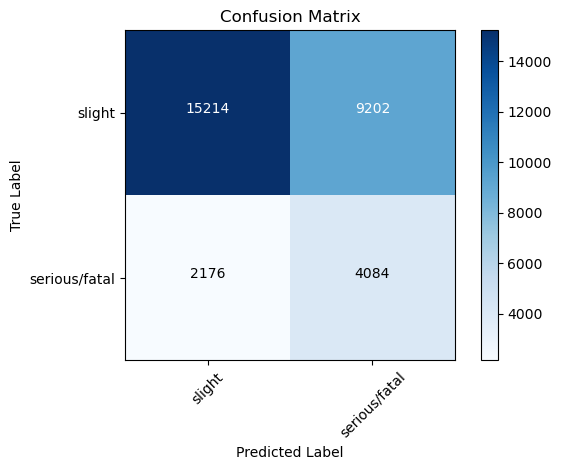

In [78]:
#plotting confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
 '''
    This function plots a confusion matrix.
    
    Parameter:
    cm(array like): Confusion matrix as returned by sklearn.metrics.confusion_matrics 
    classes(list): List of the class name, eg., ['Class 0', 'Class1']
    title(str): Title for the plot
    cmap(matplotlib colormap): colormap for the plot
 '''   
 plt.imshow(cm, interpolation='nearest', cmap=cmap)
 plt.title(title)
 plt.colorbar()
 tick_marks=np.arange(len(classes))
 plt.xticks(tick_marks, classes, rotation=45)
 plt.yticks(tick_marks, classes)

 fmt='.0f'
 thresh=cm.max()/2.0
 for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j,i, format(cm[i,j], fmt), horizontalalignment='center', color='white' if cm[i,j]>thresh else 'black')
 
 plt.ylabel('True Label')
 plt.xlabel('Predicted Label')
 plt.tight_layout()
 
#Get the confusion matrix
cm=confusion_matrix(y_test, (y_test_pred>0.5))

#plot the confusion matrix
class_names=['slight', 'serious/fatal'] #positive class should come the last
plot_confusion_matrix(cm, class_names)

# Explanation with SHAP values

Average severe accident probability is 0.2041


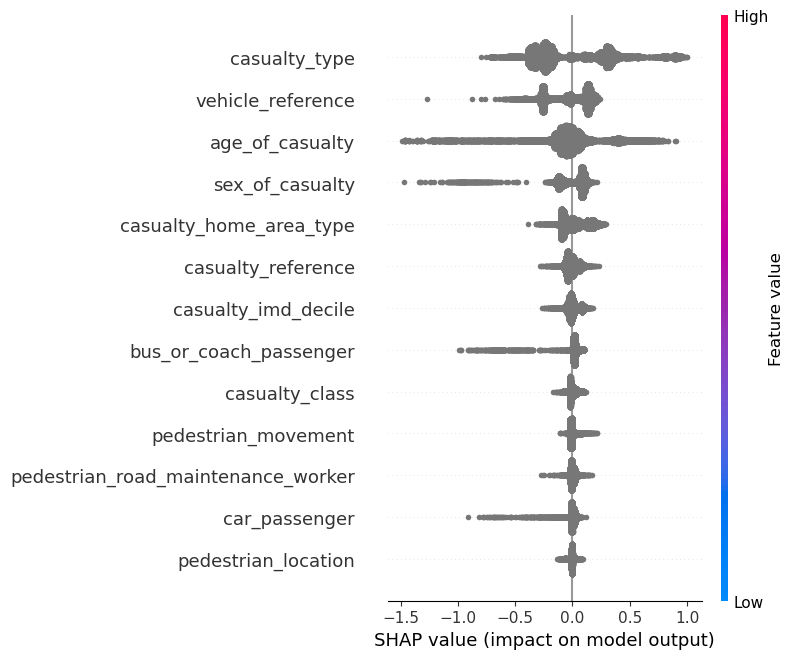

In [79]:
#Load javascript visualization code to natebook 
shap.initjs()

#explain the model's prediction using SHAP values 
ex=shap.TreeExplainer(model) # ex stands for explainer
print(f'Average severe accident probability is {round(np.mean(y_test), 4)}')
shap_values=ex.shap_values(X_test)

#visualise the prediction's explaination with default colors
shap.summary_plot(shap_values, X_test, max_display=30)


vehicle_reference


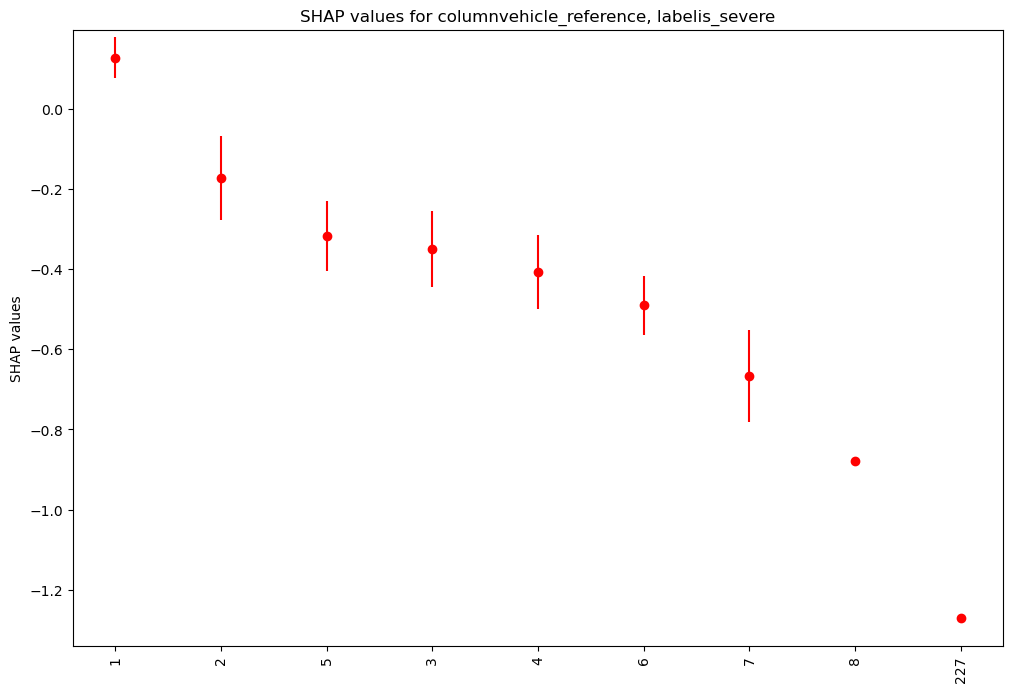

       gain  gain_std  count
col                         
1    0.1269    0.0514  18172
2   -0.1728    0.1040  11600
5   -0.3177    0.0872     36
3   -0.3506    0.0956    736
4   -0.4084    0.0920    114
6   -0.4909    0.0730     11
7   -0.6681    0.1146      5
8   -0.8782       NaN      1
227 -1.2696       NaN      1

casualty_reference


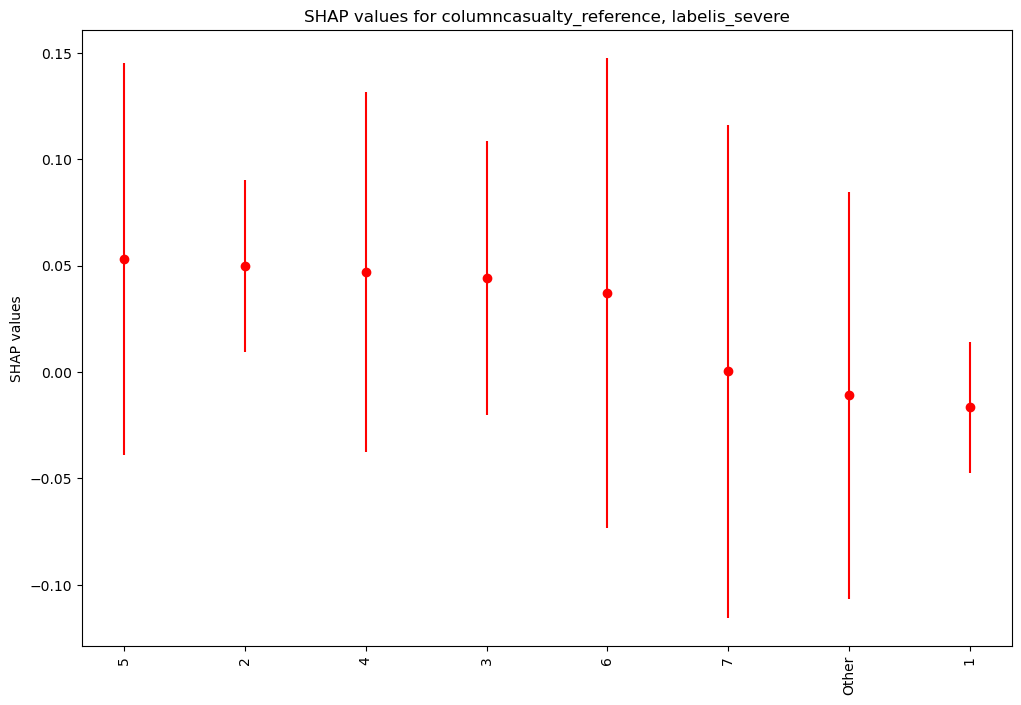

         gain  gain_std  count
col                           
5      0.0531    0.0922    161
2      0.0498    0.0404   4641
4      0.0469    0.0847    478
3      0.0441    0.0645   1403
6      0.0371    0.1104     49
7      0.0003    0.1158     19
Other -0.0109    0.0956     32
1     -0.0166    0.0309  23893

casualty_class


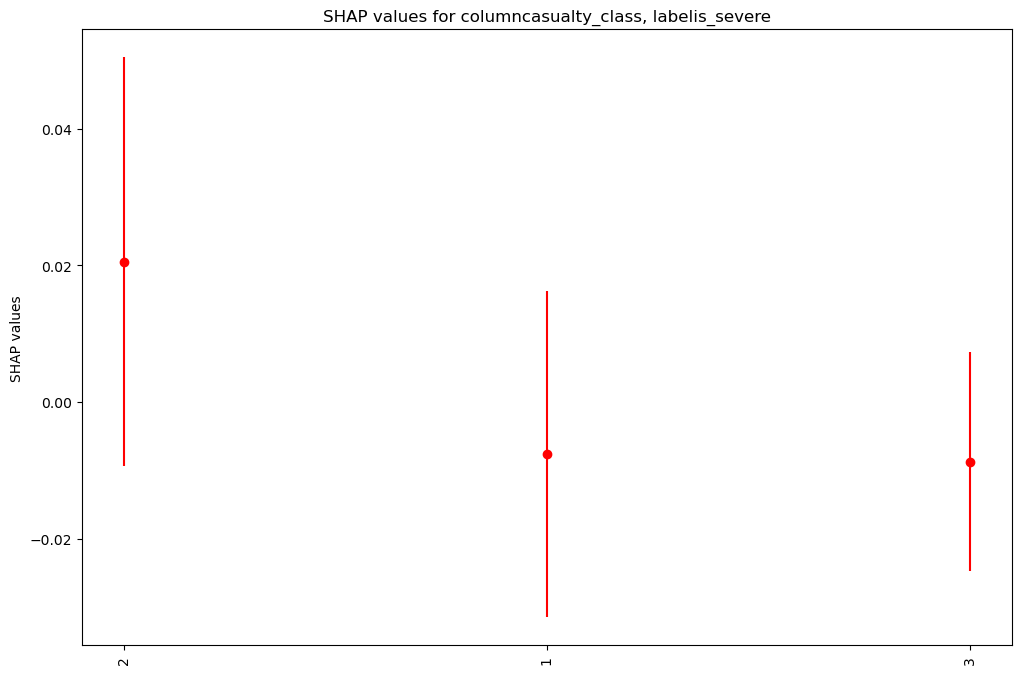

       gain  gain_std  count
col                         
2    0.0205    0.0299   5870
1   -0.0076    0.0239  20336
3   -0.0087    0.0160   4470

sex_of_casualty


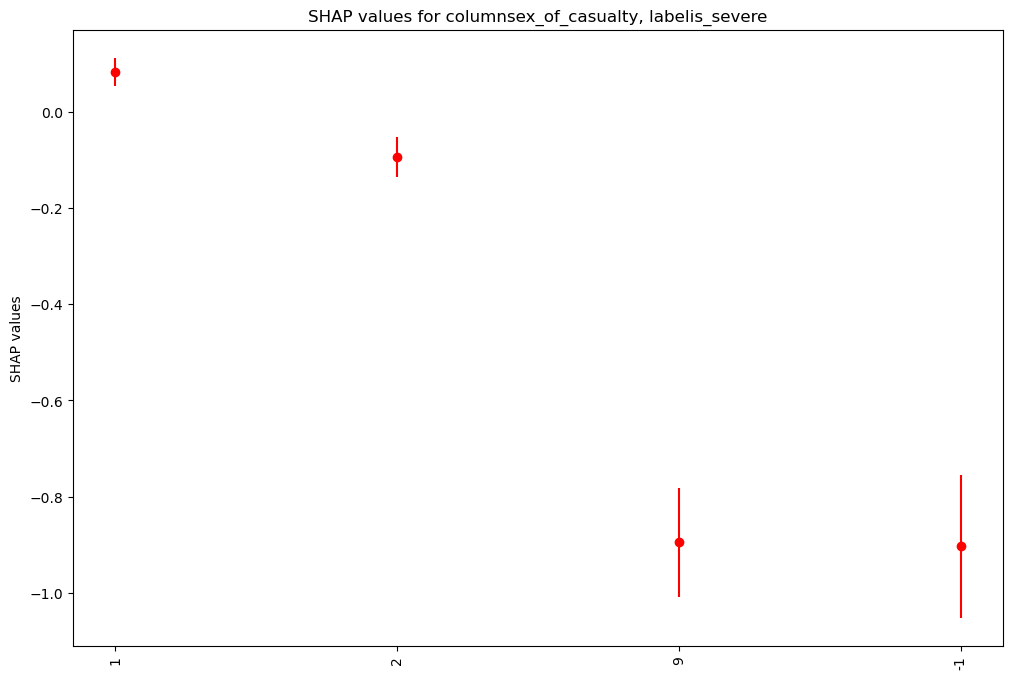

       gain  gain_std  count
col                         
1    0.0833    0.0295  18711
2   -0.0936    0.0419  11730
9   -0.8953    0.1134      3
-1  -0.9037    0.1478    232

age_of_casualty


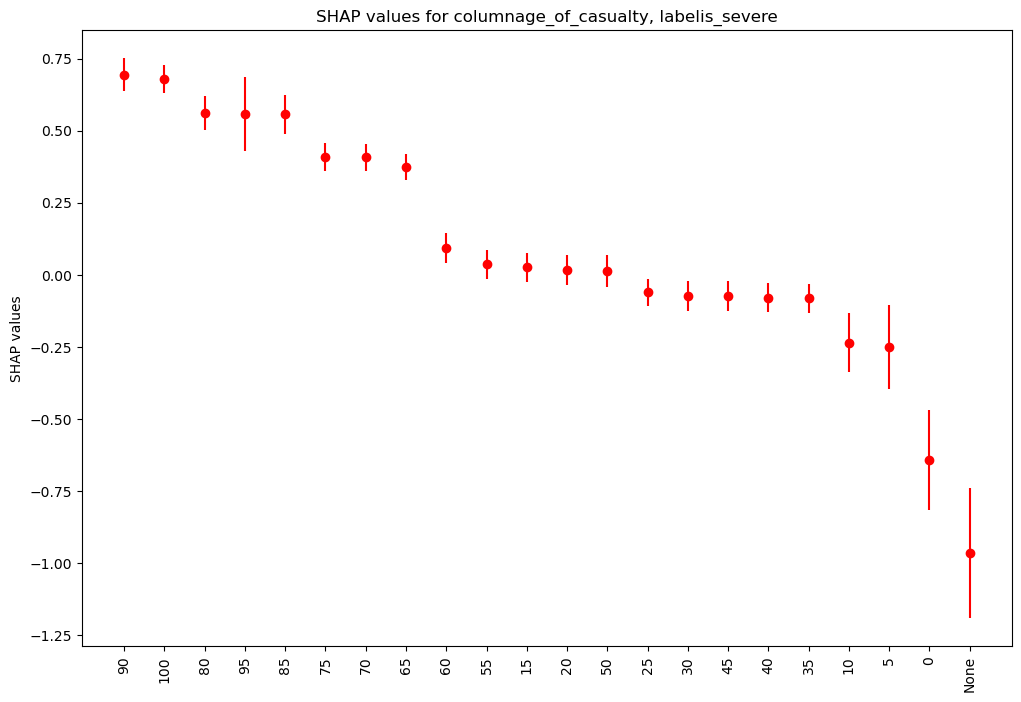

        gain  gain_std  count
col                          
90    0.6939    0.0578    146
100   0.6790    0.0491      2
80    0.5617    0.0595    450
95    0.5583    0.1287     23
85    0.5564    0.0663    344
75    0.4081    0.0495    661
70    0.4075    0.0474    753
65    0.3744    0.0445   1012
60    0.0926    0.0509   1499
55    0.0359    0.0506   1883
15    0.0268    0.0501   1776
20    0.0167    0.0504   3652
50    0.0135    0.0551   1952
25   -0.0608    0.0462   3252
30   -0.0733    0.0531   3308
45   -0.0747    0.0525   1978
40   -0.0795    0.0511   2467
35   -0.0818    0.0516   2885
10   -0.2355    0.1033   1153
5    -0.2500    0.1452    637
0    -0.6433    0.1735    172
None -0.9650    0.2261    671

pedestrian_location


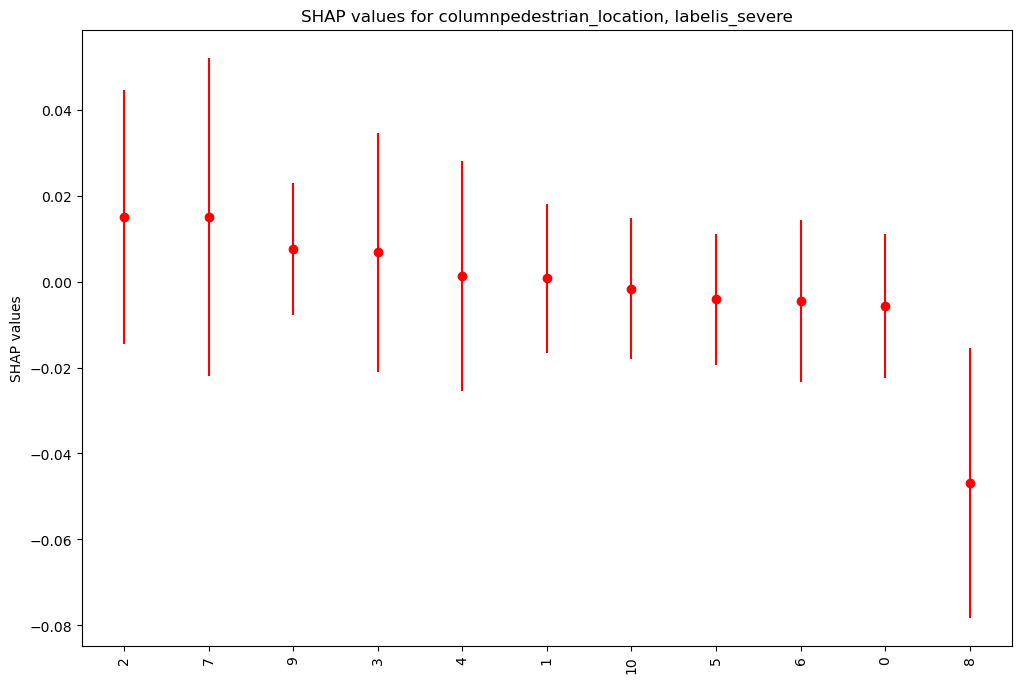

       gain  gain_std  count
col                         
2    0.0151    0.0296     21
7    0.0151    0.0371     35
9    0.0076    0.0153    477
3    0.0068    0.0278     14
4    0.0014    0.0268    274
1    0.0008    0.0173    720
10  -0.0016    0.0165    434
5   -0.0041    0.0152   1704
6   -0.0045    0.0189    532
0   -0.0057    0.0167  26206
8   -0.0468    0.0314    259

pedestrian_movement


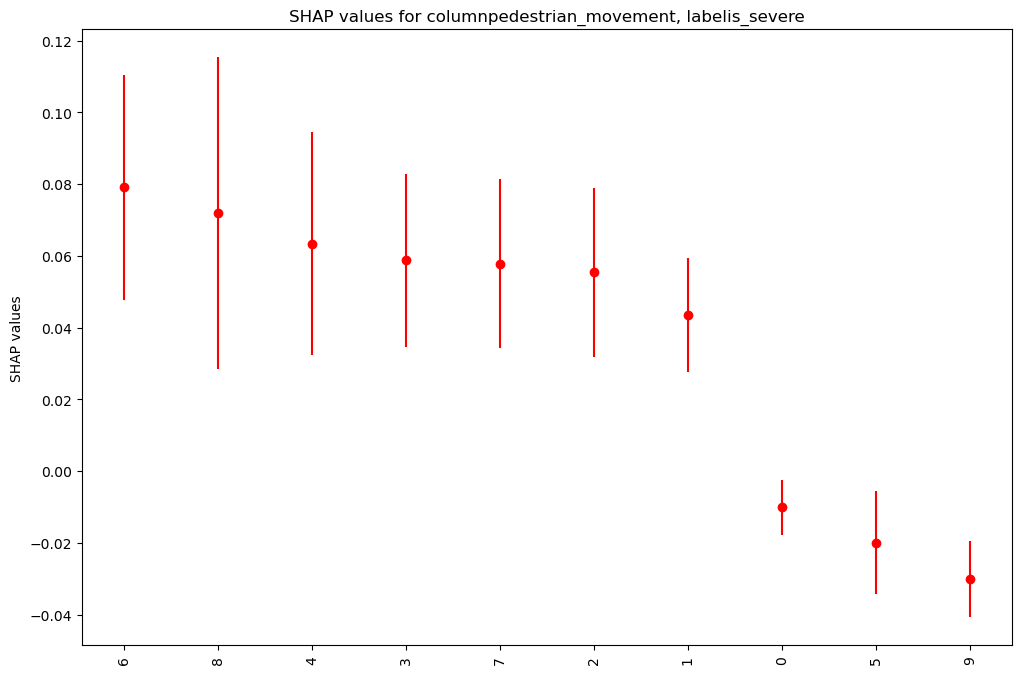

       gain  gain_std  count
col                         
6    0.0791    0.0314     36
8    0.0719    0.0434    106
4    0.0634    0.0310    147
3    0.0587    0.0242    928
7    0.0578    0.0236    115
2    0.0554    0.0236    210
1    0.0434    0.0159   1409
0   -0.0101    0.0077  26205
5   -0.0200    0.0143    236
9   -0.0301    0.0107   1284

car_passenger


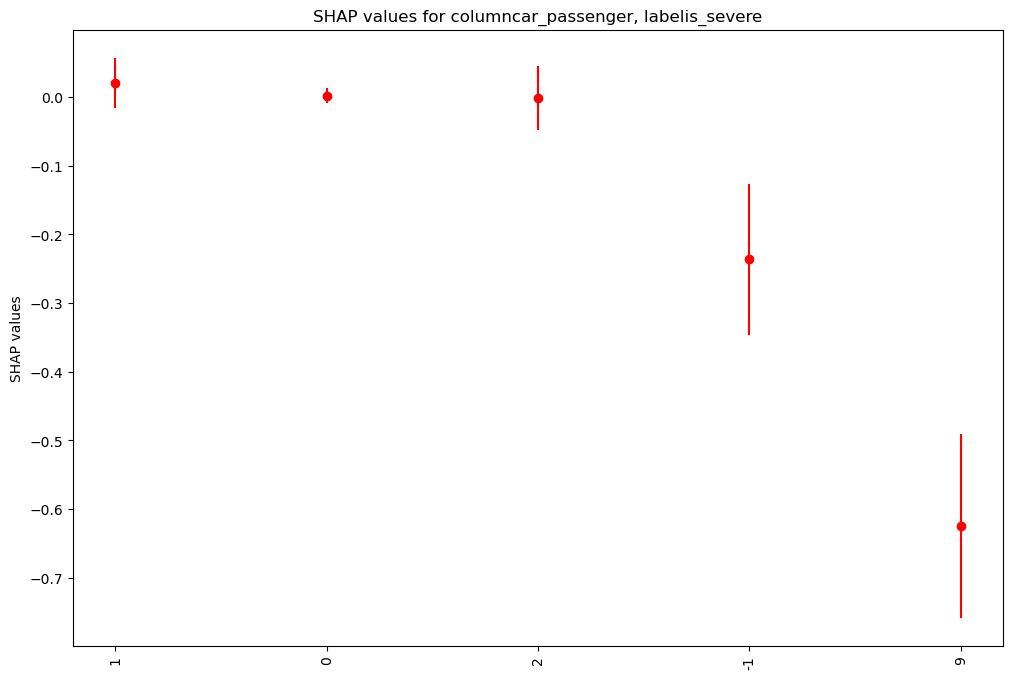

       gain  gain_std  count
col                         
1    0.0208    0.0368   3084
0    0.0023    0.0113  25598
2   -0.0012    0.0465   1782
-1  -0.2363    0.1103    171
9   -0.6245    0.1333     41

bus_or_coach_passenger


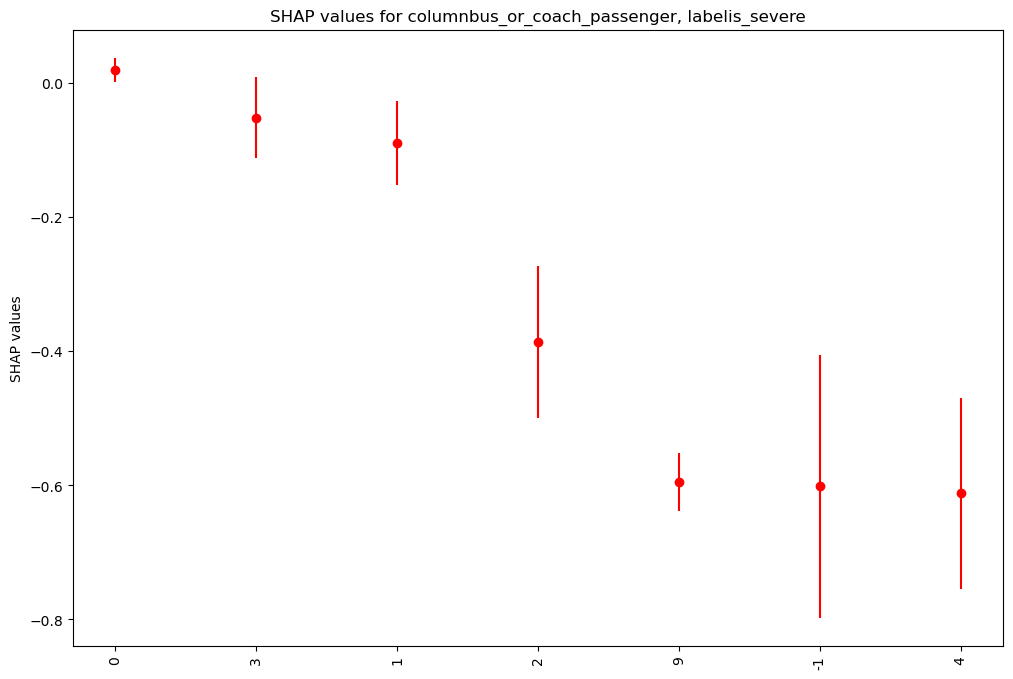

       gain  gain_std  count
col                         
0    0.0192    0.0183  30246
3   -0.0521    0.0605    127
1   -0.0894    0.0627     10
2   -0.3867    0.1132     32
9   -0.5947    0.0430      2
-1  -0.6012    0.1959     13
4   -0.6119    0.1426    246

pedestrian_road_maintenance_worker


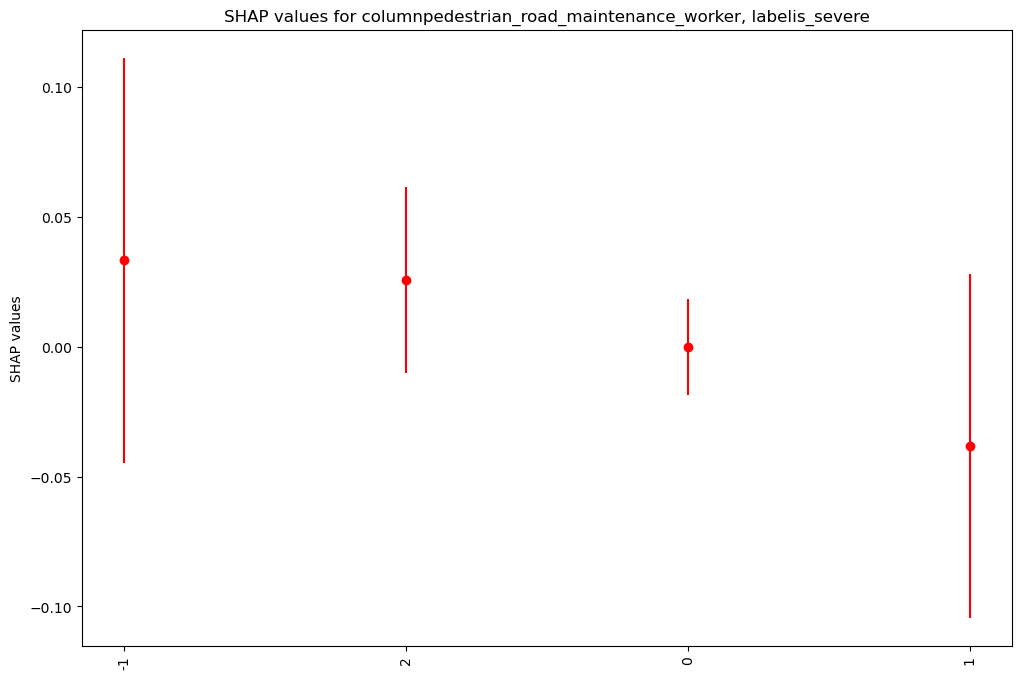

       gain  gain_std  count
col                         
-1   0.0333    0.0781     51
2    0.0257    0.0359    550
0   -0.0002    0.0184  30010
1   -0.0382    0.0661     65

casualty_type


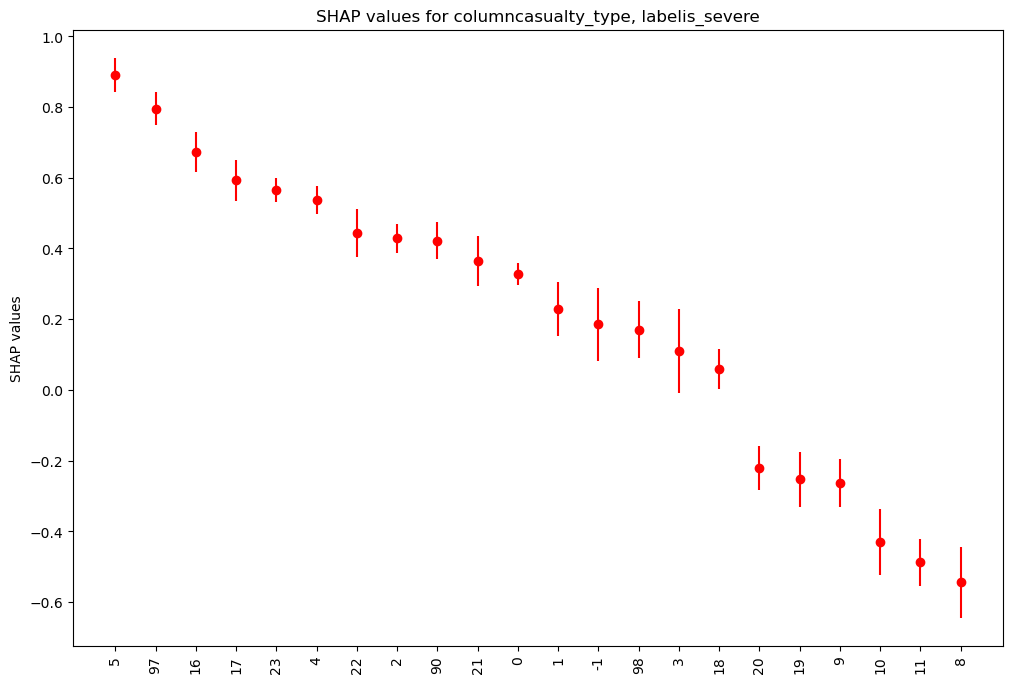

       gain  gain_std  count
col                         
5    0.8919    0.0483    897
97   0.7959    0.0454    437
16   0.6728    0.0557     14
17   0.5934    0.0581     13
23   0.5661    0.0340     65
4    0.5375    0.0397    421
22   0.4439    0.0676     56
2    0.4285    0.0412    230
90   0.4217    0.0519    398
21   0.3648    0.0707     97
0    0.3282    0.0309   4470
1    0.2293    0.0767   3548
-1   0.1851    0.1043      4
98   0.1696    0.0804    196
3    0.1105    0.1182   1823
18   0.0586    0.0561      3
20  -0.2223    0.0624     39
19  -0.2530    0.0776    731
9   -0.2648    0.0678  16370
10  -0.4302    0.0932     46
11  -0.4878    0.0669    473
8   -0.5442    0.1000    345

casualty_home_area_type


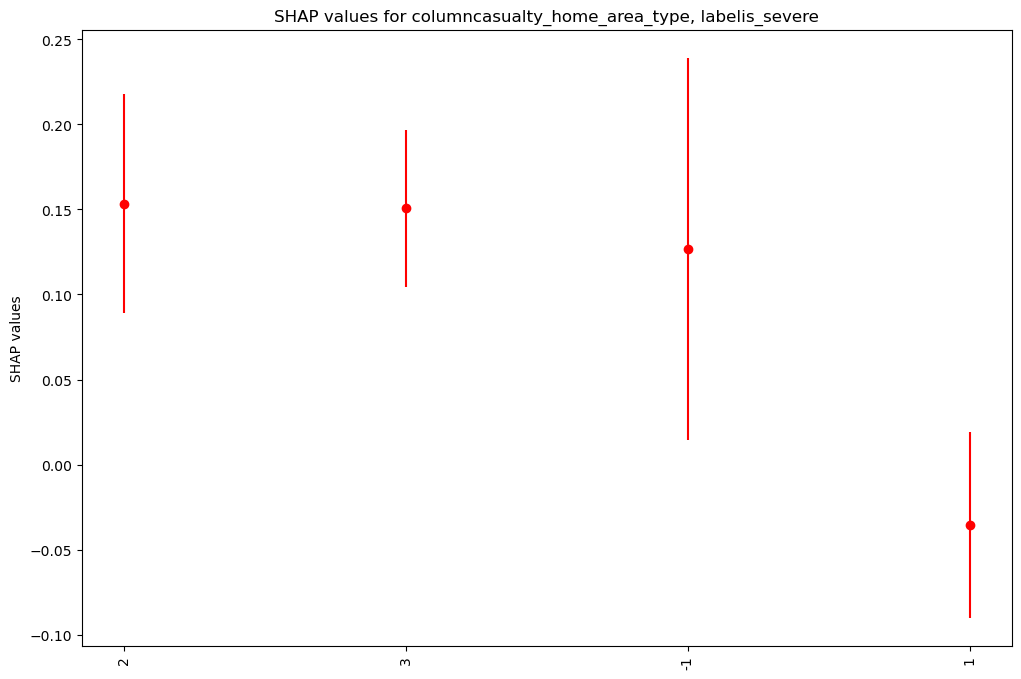

       gain  gain_std  count
col                         
2    0.1534    0.0642   2201
3    0.1506    0.0462   2974
-1   0.1269    0.1124   2777
1   -0.0353    0.0546  22724

casualty_imd_decile


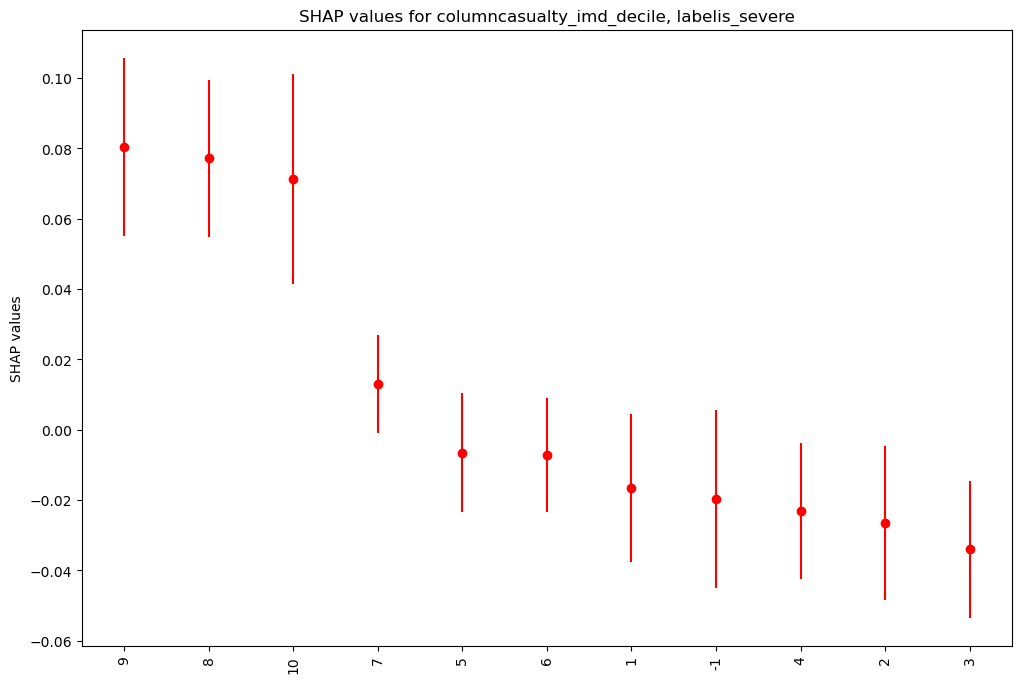

       gain  gain_std  count
col                         
9    0.0805    0.0253   2022
8    0.0771    0.0224   2267
10   0.0712    0.0299   1835
7    0.0129    0.0139   2493
5   -0.0066    0.0169   2887
6   -0.0073    0.0162   2662
1   -0.0165    0.0210   3460
-1  -0.0197    0.0253   2925
4   -0.0232    0.0193   3163
2   -0.0266    0.0219   3514
3   -0.0340    0.0194   3448


In [84]:
def show_shap(col, shap_values=shap_values, label=main_label, X_test=X_test, ylabel='SHAP values'):
 df_infl=X_test.copy()
 df_infl['shap_']= shap_values[:, df_infl.columns.tolist().index(col)]
 gain= round(df_infl.groupby(col).mean()['shap_'], 4) 
 gain_std= round(df_infl.groupby(col).std()['shap_'], 4)
 cnt=df_infl.groupby(col).count()['shap_']
 dd_dict={'col': list(gain.index), 'gain': list(gain.values), 'gain_std': list(gain_std.values), 'count':cnt}
 df_res=pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending= False).set_index('col')
 plt.figure(figsize=(12,8))
 plt.errorbar(df_res.index, df_res['gain'], yerr=df_res['gain_std'], fmt='o', color='r')
 plt.title(f'SHAP values for column{col}, label{label}')
 plt.ylabel(ylabel)
 plt.tick_params(axis='x', rotation=90)
 plt.show();
 print(df_res)
 return           

for col in X_test.columns:
 print()
 print(col)
 print
 show_shap(col,shap_values, label=main_label, X_test=X_test)           